In [2]:
# IMPORTING ALL NECESSARY PACKAGES


# Install main libraries
!pip install opencv-python scikit-image scikit-learn matplotlib seaborn joblib streamlit

# Install imbalanced-learn
!pip install imbalanced-learn





[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# ALL IMPORTS AND INITIAL DATASET ORIENTATION AND CHECKING VERSIONS JUST FOR COMPATIBILITY

import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC           # <--- THIS LINE IS CRUCIAL
from sklearn.neighbors import KNeighborsClassifier # <--- THIS LINE IS CRUCIAL
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib # To save/load models and scalers

print(f"OpenCV Version: {cv2.__version__}")
print(f"Scikit-image Version: {__import__('skimage').__version__}")
print(f"Scikit-learn Version: {__import__('sklearn').__version__}")



    

dataset_path = os.path.join("dataset")
testing_image_folder = "testing image" 
testing_path = os.path.join(testing_image_folder)

print("\nDataset exists?", os.path.exists(dataset_path))
print("Testing folder exists?", os.path.exists(testing_path))

data_structure = {
    "real/500": 0,
    "real/2000": 0,
    "fake/500": 1,
    "fake/2000": 1,
    "fake/Features/500_Features": 1,
    "fake/Features/2000_Features": 1
}


IMG_SIZE = (128, 128) # Width, Height

OpenCV Version: 4.11.0
Scikit-image Version: 0.25.2
Scikit-learn Version: 1.5.1

Dataset exists? True
Testing folder exists? True


In [6]:
# FEATURES EXTRACTION->

def extract_hog_features(img_path_or_array):
    
    if isinstance(img_path_or_array, str):
        img_color = cv2.imread(img_path_or_array, cv2.IMREAD_COLOR)
    else: 
        img_color = img_path_or_array
    
    if img_color is None:
        return None
        
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, IMG_SIZE)
    
    # USING HOG PARARMETERS
    features = hog(img_resized, 
                 orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(2, 2),
                 block_norm='L2-Hys',
                 visualize=False,
                 transform_sqrt=True)
    return features

def extract_color_features(img_path_or_array):
    
    if isinstance(img_path_or_array, str):
        img_color = cv2.imread(img_path_or_array, cv2.IMREAD_COLOR)
    else: 
        img_color = img_path_or_array

    if img_color is None:
        return None

    img_resized = cv2.resize(img_color, IMG_SIZE)
    
    # Convert to HSV color space
    hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
    
    # Calculate color histogram
    
    hist_hsv = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    hist_hsv = hist_hsv.flatten() # Flatten the 3D histogram into a 1D feature vector
    
    # Normalize the histogram 
    
    return hist_hsv

# Helper function to combine features for a single image
def get_combined_features_for_image(img_path_or_array):
    hog_feats = extract_hog_features(img_path_or_array)
    color_feats = extract_color_features(img_path_or_array)
    
    if hog_feats is None or color_feats is None:
        return None
    
    combined_features = np.concatenate([hog_feats, color_feats])
    return combined_features

In [7]:
# DATA LOADING AND COMBINING DIFFERENT FUNCTIONS->

def load_and_extract_all_features(dataset_base_path, data_structure_map):
    all_features, all_labels = [], []
    
    print("\nLOADING AND EXTRACTING FEATURES:")

    
    image_count_per_label = defaultdict(int)

    for rel_path, label in data_structure_map.items():
        full_path = os.path.join(dataset_base_path, rel_path)
        if not os.path.exists(full_path):
            print(f" Folder missing: {full_path}")
            continue
            
        loaded_count = 0
        for img_name in os.listdir(full_path):
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
                
            img_path = os.path.join(full_path, img_name)
            
            combined_feats = get_combined_features_for_image(img_path)
            
            if combined_feats is not None:
                all_features.append(combined_feats)
                all_labels.append(label)
                loaded_count += 1
        
        print(f" {rel_path:35} - {loaded_count:2} images loaded & features extracted")
        image_count_per_label[label] += loaded_count # Count images per label (0 or 1)

    return np.array(all_features), np.array(all_labels), image_count_per_label

# Executing the loading and extraction
X, y, class_counts = load_and_extract_all_features(dataset_path, data_structure)
print(f"\nTOTAL IMAGES LOADED & FEATURES EXTRACTED: {len(X)} images")
print(f"Class balance - Real (0): {class_counts[0]}, Fake (1): {class_counts[1]}")


LOADING AND EXTRACTING FEATURES:
 real/500                            -  8 images loaded & features extracted
 real/2000                           -  7 images loaded & features extracted
 fake/500                            -  6 images loaded & features extracted
 fake/2000                           -  6 images loaded & features extracted
 fake/Features/500_Features          -  7 images loaded & features extracted
 fake/Features/2000_Features         -  7 images loaded & features extracted

TOTAL IMAGES LOADED & FEATURES EXTRACTED: 41 images
Class balance - Real (0): 15, Fake (1): 26


In [11]:
# TRAIN-TEST SPLIT AND FEATURE EXTRACTION


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) 

print(f"\nTrain set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"Train class balance - Real: {sum(y_train==0)}, Fake: {sum(y_train==1)}")
print(f"Test class balance - Real: {sum(y_train==1)}, Fake: {sum(y_train==0)}") 
print(f"Test class balance - Real: {sum(y_test==0)}, Fake: {sum(y_test==1)}")

# Feature Scaling: Essential for SVM and KNN to perform well.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)       

# Save the scaler for later use in the Streamlit app.
scaler_filename = "scaler.pkl"
joblib.dump(scaler, scaler_filename)
print(f"\nScaler saved to {scaler_filename}")


Train set size: 28 samples
Test set size: 13 samples
Train class balance - Real: 10, Fake: 18
Test class balance - Real: 18, Fake: 10
Test class balance - Real: 5, Fake: 8

Scaler saved to scaler.pkl



Training SVM Model: 

 SVM Classification Report on Test Set:
              precision    recall  f1-score   support

        Real       1.00      0.40      0.57         5
        Fake       0.73      1.00      0.84         8

    accuracy                           0.77        13
   macro avg       0.86      0.70      0.71        13
weighted avg       0.83      0.77      0.74        13


SVM Confusion Matrix:
[[2 3]
 [0 8]]


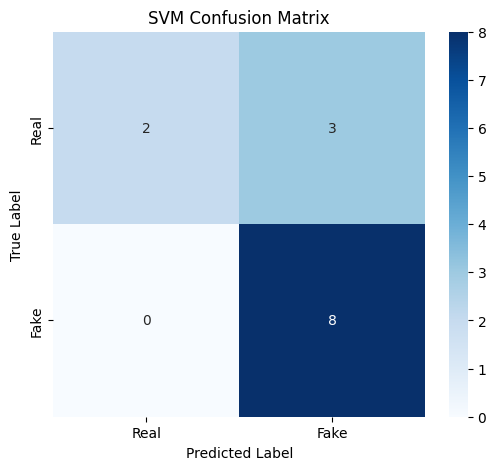


--- Training KNN Model with GridSearchCV ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best KNN params: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Best KNN score (F1 weighted): 0.8342857142857142

KNN Classification Report on Test Set (Best Estimator):
              precision    recall  f1-score   support

        Real       0.83      1.00      0.91         5
        Fake       1.00      0.88      0.93         8

    accuracy                           0.92        13
   macro avg       0.92      0.94      0.92        13
weighted avg       0.94      0.92      0.92        13


KNN Confusion Matrix:
[[5 0]
 [1 7]]


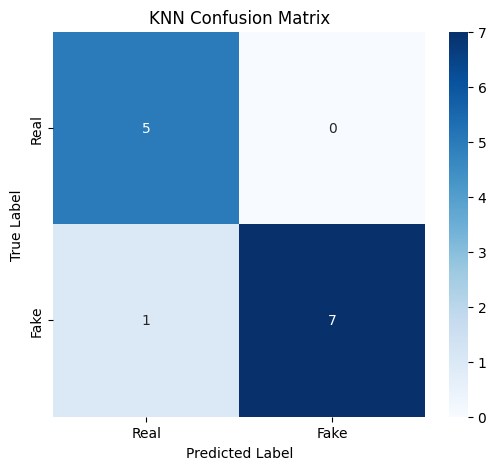

In [9]:
 # MODEL TRAINING WITH SVM AND KNN WITH GRID SEARCH

# Support Vector Machine (SVM)
print("\nTraining SVM Model: ")
# probability=True allows for `predict_proba` which might be useful later.
# random_state for reproducibility.
svm_model = SVC(kernel='rbf', probability=True, random_state=42) 
svm_model.fit(X_train_scaled, y_train)

# Evaluate SVM
y_pred_svm = svm_model.predict(X_test_scaled)
print("\n SVM Classification Report on Test Set:")
# target_names for clearer output
print(classification_report(y_test, y_pred_svm, target_names=['Real', 'Fake']))

# Confusion Matrix for SVM
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print("\nSVM Confusion Matrix:")
print(conf_matrix_svm)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix')
plt.show()

# K-Nearest Neighbors (KNN) with GridSearchCV
print("\n--- Training KNN Model with GridSearchCV ---")
knn = KNeighborsClassifier()
params = {
    'n_neighbors': [1, 3, 5, 7], # Hyperparameters to search
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# GridSearchCV performs exhaustive search over specified parameter values for an estimator.
# cv: number of folds in a (Stratified)KFold
# scoring: metric to evaluate the models (f1_weighted is good for imbalanced classification)
# n_jobs=-1: use all available CPU cores for faster search
grid_knn = GridSearchCV(knn, params, cv=min(5, len(X_train)), scoring='f1_weighted', n_jobs=-1, verbose=1) 
# cv=min(5, len(X_train)) ensures cv doesn't exceed number of samples in training set
grid_knn.fit(X_train_scaled, y_train)

print("\nBest KNN params:", grid_knn.best_params_)
print("Best KNN score (F1 weighted):", grid_knn.best_score_)

# Evaluate best KNN model
best_knn_model = grid_knn.best_estimator_ # Get the best model from GridSearchCV
y_pred_knn = best_knn_model.predict(X_test_scaled)
print("\nKNN Classification Report on Test Set (Best Estimator):")
print(classification_report(y_test, y_pred_knn, target_names=['Real', 'Fake']))

# Confusion Matrix for KNN
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print("\nKNN Confusion Matrix:")
print(conf_matrix_knn)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('KNN Confusion Matrix')
plt.show()

In [12]:
# Save the best KNN model as it performed better
model_to_save = best_knn_model # This should now exist!
model_filename = "knn_model.pkl" # Changed filename to reflect KNN

joblib.dump(model_to_save, model_filename)
print(f"\nBest performing model (KNN) saved to {model_filename}")


Best performing model (KNN) saved to knn_model.pkl


In [13]:


#  1. Essential Imports 
import joblib
import os
import cv2
import numpy as np
from skimage.feature import hog 

#2. Configuration 
MODEL_PATH = "knn_model.pkl" 
SCALER_PATH = "scaler.pkl"
IMG_SIZE = (128, 128) # The size you resized images to for feature extraction


dataset_base_path = "dataset"
testing_images_folder = "testing image"





#  3. Load Trained Model and Scaler 
loaded_model = None 
loaded_scaler = None 

try:
    loaded_model = joblib.load(MODEL_PATH)
    loaded_scaler = joblib.load(SCALER_PATH)
    print("Model and Scaler loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: Model '{MODEL_PATH}' or Scaler '{SCALER_PATH}' not found.")
    print("Please ensure you've run all previous cells in main.ipynb to train and save them.")

except Exception as e:
    print(f"AN UNEXPECTED ERROR OCCURRED while loading model/scaler: {e}")

# IMPORTANT: Check if loading was successful before proceeding 
if loaded_model is None or loaded_scaler is None:
    print("\nAborting use case testing as model/scaler could not be loaded.")
  
else:
    # 4. Feature Extraction Functions
    def extract_hog_features_for_test(img_array):
        img_gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.resize(img_gray, IMG_SIZE)
        features = hog(img_resized, orientations=9, pixels_per_cell=(8,8),
                       cells_per_block=(2,2), block_norm='L2-Hys', visualize=False, transform_sqrt=True)
        return features

    def extract_color_features_for_test(img_array):
        img_resized = cv2.resize(img_array, IMG_SIZE)
        hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
        hist_hsv = cv2.calcHist([hsv], [0,1,2], None, [8,8,8], [0,180,0,256,0,256])
        hist_hsv = hist_hsv.flatten()
        return hist_hsv

    def get_combined_features_for_test(img_path):
        img_original = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img_original is None:
            print(f"Warning: Could not read image at {img_path}")
            return None
        
        hog_feats = extract_hog_features_for_test(img_original)
        color_feats = extract_color_features_for_test(img_original)
        
        if hog_feats is None or color_feats is None:
            return None
        
        return np.concatenate([hog_feats, color_feats])


# 5. Define Specific Test Cases (Image Paths) 

    test_image_paths = [
        os.path.join(dataset_base_path, "real", "500", "500_original_IMG_20190419_211825754.jpg_7d8a3d1a-f14a-4faf-ac9c-927a50f3b420 (1).jpg"), # Example Real 500
        os.path.join(dataset_base_path, "fake", "500", "500_f4.jpg"), # Example Fake 500
        os.path.join(testing_images_folder, "500_s5.jpg"),
        os.path.join(testing_images_folder, "2000_s5.jpg"),
        # Add more paths here if you want to test more specific images
    ]
# 6. Run Prediction for Each Test Case
    for i, img_path in enumerate(test_image_paths):
        print(f"\nTest Case {i+1}: {os.path.basename(img_path)}")
        
        if not os.path.exists(img_path):
            print(f"  Image not found: {img_path}. Skipping.")
            continue

        features = get_combined_features_for_test(img_path)
        
        if features is not None:
            scaled_features = loaded_scaler.transform([features])
            prediction = loaded_model.predict(scaled_features)[0]
            
            result = "REAL Note" if prediction == 0 else "COUNTERFEIT Note"
            print(f"  Prediction: {result}")
        else:
            print(f"  Could not process image {os.path.basename(img_path)}.")



Model and Scaler loaded successfully.

Test Case 1: 500_original_IMG_20190419_211825754.jpg_7d8a3d1a-f14a-4faf-ac9c-927a50f3b420 (1).jpg
  Prediction: REAL Note

Test Case 2: 500_f4.jpg
  Prediction: COUNTERFEIT Note

Test Case 3: 500_s5.jpg
  Prediction: COUNTERFEIT Note

Test Case 4: 2000_s5.jpg
  Prediction: COUNTERFEIT Note


In [14]:
cd C:\Users\ASUS\Desktop\blackbucks ds\cmd-1

C:\Users\ASUS\Desktop\blackbucks ds\cmd-1


C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
